In [1]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# System Equations

### Linearizing $\ddot{x}$ and $\ddot{y}$

The dynamics of the drone in the x-direction can be described by the following equation:

$$
m \ddot{x} = \text{thrust} \cdot \sin(\theta)
$$

Assuming the drone is in a near-hover state, we can equate the thrust to the weight of the drone, i.e., $\text{thrust} = m \cdot g$. Substituting this into the equation, we get:

$$
\ddot{x} = g \cdot \sin(\theta)
$$

To simplify the model for small angles, we linearize $\sin(\theta)$ around 0. This leads to the following approximation:

$$
\ddot{x} \approx g \cdot \theta
$$

### Linearizing Thrust

The thrust in the context of vertical dynamics can be expressed as:

$$
\text{thrust} = m \cdot \frac{\ddot{z} + g}{\cos(\theta) \cdot \cos(\phi)}
$$

For small angles, we approximate $\cos(\theta)$ and $\cos(\phi)$ as 1. Hence, the equation simplifies to:

$$
\text{thrust} \approx m \cdot (\ddot{z} + g)
$$

From this approximation, we derive the vertical acceleration:

$$
\ddot{z} = \frac{\text{thrust} - \text{m} \cdot \text{g}}{m}
$$

These linearizations facilitate the analysis and control design for the drone in its near-hover state.

### System Matrices with States $x$, $y$, $z$, $\dot{x}$, $\dot{y}$, and $\dot{z}$

For the given system states, the matrices A, B, and C are defined as follows:

**Matrix A (State Transition Matrix):**

$$
A = \begin{bmatrix}
      0 & 0 & 0 & 1 & 0 & 0 \\
      0 & 0 & 0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 0 & 0 & 1 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
      0 & 0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
$$

**Matrix B (Control Matrix):**

$$
B = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & 0 \\
      0 & 0 & 0 \\
      g & 0 & 0 \\
      0 & g & 0 \\
      0 & 0 & \frac{1}{m} \\
    \end{bmatrix}
$$

**Matrix C (Output Matrix):**

$$
C = \begin{bmatrix}
      1 & 0 & 0 & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 & 0 & 0 \\
      0 & 0 & 1 & 0 & 0 & 0 \\
    \end{bmatrix}
$$

These matrices represent the linearized model of the drone's motion, with $A$ describing the system dynamics, $B$ showing how control inputs affect the state, and $C$ representing the measured outputs.


# LQR Matrices

For the implementation of LQR (Linear Quadratic Regulator), specific matrices are used to define system dynamics and measurement models.

**Matrix Q (State-Cost Matrix):**

$$
Q = \begin{bmatrix}
      1 & 0 & 0 & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 & 0 & 0 \\
      0 & 0 & 1 & 0 & 0 & 0 \\
      0 & 0 & 0 & 1 & 0 & 0 \\
      0 & 0 & 0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix}
$$

**Matrix R (Control-Cost Matrix):**

$$
R = \begin{bmatrix}
      1 & 0 & 0 \\
      0 & 1 & 0 \\
      0 & 0 & 100 \\
    \end{bmatrix}
$$

In [2]:
bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQR_after_trim.bag')

position_optitrack = []
desired_position = []
vel_optitrack = []
desired_vel = []
control_input = []

for topic, msg, t in bag.read_messages(topics=['position_Optitrack', 'vel_Optitrack', 'desired_position', 'desired_vel', 'control_input']):
    
    if topic == 'position_Optitrack':
        position_optitrack.append((msg.x, msg.y, msg.z))
        
    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_position':
        desired_position.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_vel':
        desired_vel.append((msg.x, msg.y, msg.z))
    
    if topic == 'control_input':
        control_input.append((msg.x, msg.y, msg.z))
bag.close()

position_optitrack = np.array(position_optitrack)
vel_optitrack = np.array(vel_optitrack)
desired_position = np.array(desired_position)
desired_vel = np.array(desired_vel)
control_input = np.array(control_input)

In [3]:
time = []
initial_time = 0
Ts = 1/30

for i in range(len(position_optitrack)):
    time.append(initial_time)
    initial_time+=Ts

# X accel vs angle

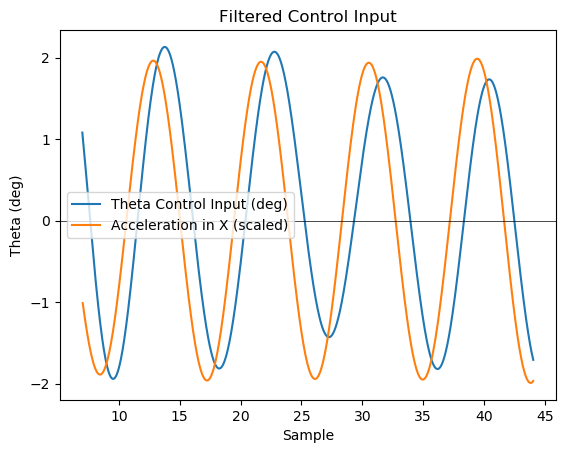

In [4]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 0]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 0]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 18
min_t = 7
plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='Theta Control Input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in X (scaled)')

plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [5]:
np.mean(filtered_control_input_deg[min_t*30:-max_t*30])

0.06758932785106668

In [6]:
3.48-1.57

1.91

# Y accel vs angle

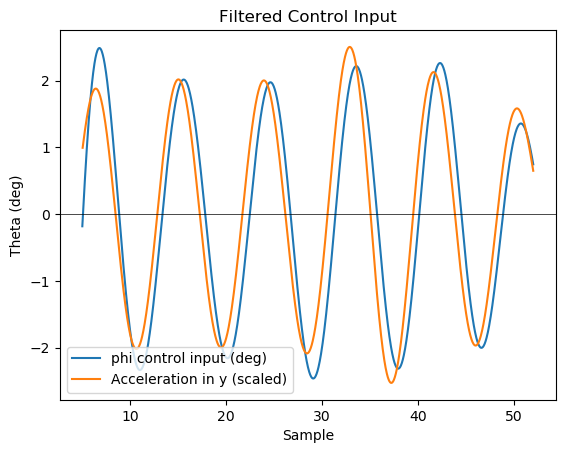

In [7]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 1]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 1]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 10
min_t = 5

plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='phi control input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in y (scaled)')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [8]:
np.mean(filtered_control_input_deg[min_t*30:-max_t*30])

0.007033753609597994

# X

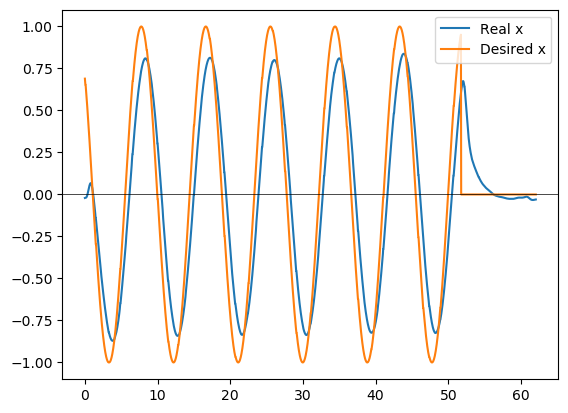

In [9]:
plt.plot(time, [x[0] for x in position_optitrack], label='Real x')
plt.plot(time, [x[0] for x in desired_position], label='Desired x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### X RMSE

In [10]:
x_square_error = (desired_position[:, 0] - position_optitrack[:, 0])**2
x_mse = np.sqrt(np.mean(x_square_error))
x_mse

0.27236870442811356

# Y

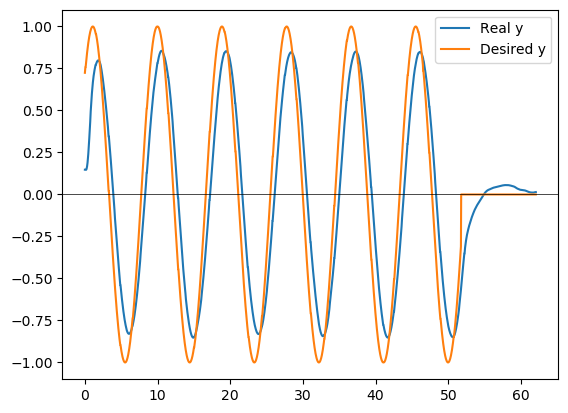

In [11]:
plt.plot(time, [x[1] for x in position_optitrack], label='Real y')
plt.plot(time, [x[1] for x in desired_position], label='Desired y')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### Y MSE

In [12]:
y_square_error = (desired_position[:, 1] - position_optitrack[:, 1])**2
y_mse = np.sqrt(np.mean(y_square_error))
y_mse

0.27217777365117096

# Z

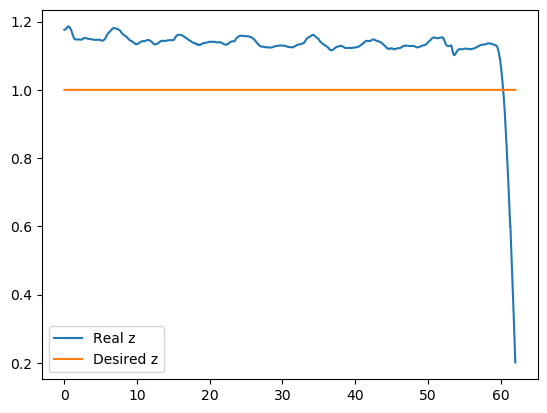

In [13]:
plt.plot(time, [x[2] for x in position_optitrack], label='Real z')
plt.plot(time, [x[2] for x in desired_position], label='Desired z')

plt.legend()
plt.show()

acc max used = 13.72

### Mean z position

In [14]:
np.mean(position_optitrack[:-5*30, 2])

1.139577220324601

## Mean thrust

In [15]:
np.mean(np.array(control_input)[:-5*30, 2])/0.032 # Should be equal the gravity

10.224950438361851

In [16]:
(10.224950438361851/9.81)*13.72 # Correcting the a_max

14.300338431633495

### Results

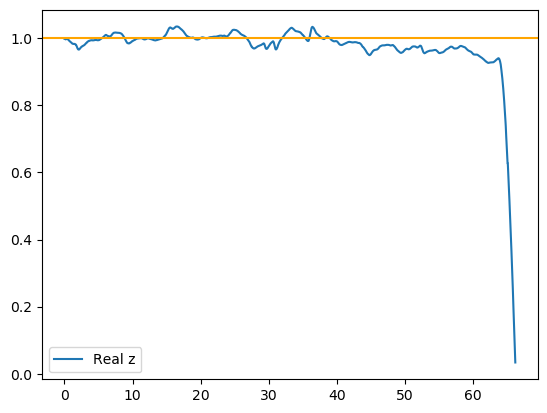

In [17]:
bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQR_after_amax_trim.bag')

position_optitrack = []

for topic, msg, t in bag.read_messages(topics=['position_Optitrack']):
    position_optitrack.append((msg.x, msg.y, msg.z))

bag.close()

position_optitrack = np.array(position_optitrack)
z_position = position_optitrack[:, 2]

time = []
initial_time = 0
Ts = 1/30

for i in range(len(z_position)):
    time.append(initial_time)
    initial_time+=Ts

plt.plot(time, [x for x in z_position], label='Real z')
plt.axhline(y=1, color='orange', linewidth=1.5)
plt.legend()
plt.show()

# Control Effort

## Theta

In [18]:
def control_effort(u):
    effort = 0
    for i in range(len(u) - 1):
        effort += u[i+1]-u[i]

    return effort

control_effort(np.array(control_input)[:, 0])

-0.14555874056117118

## phi

In [19]:
control_effort(np.array(control_input)[:, 1])

-0.26934239089097406

## Thrust

In [20]:
control_effort(np.array(control_input)[:, 2])

0.15622823482693715

# Conclusion

The LQR (Linear Quadratic Regulator) displayed impressive results, underscoring the significance of accurately estimating the drone's maximum achievable acceleration to avoid errors in the steady-state regime. In terms of positioning, this controller is much quicker compared to the H infinity controller, although it falls behind in trajectory tracking performance.